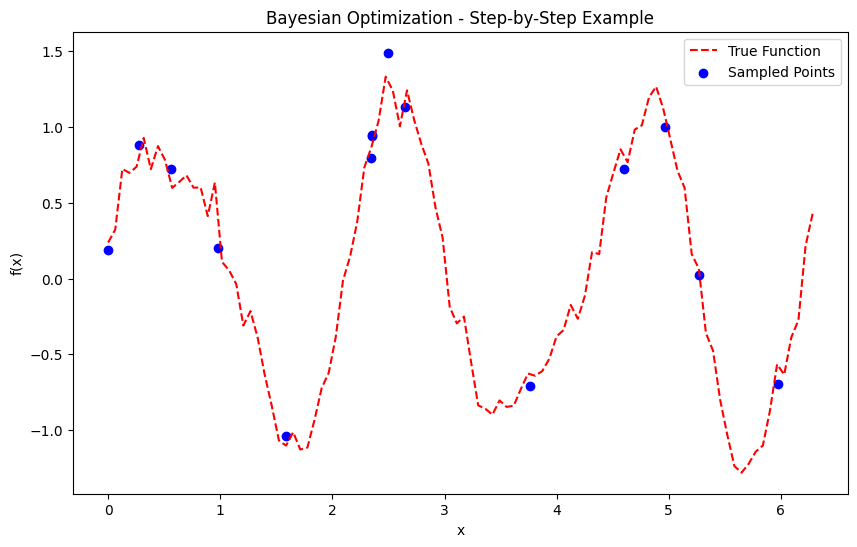

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Step 1: Define the noisy objective function
def objective_function(x):
    noise = np.random.normal(0, 0.1)  # Add Gaussian noise
    return np.sin(3*x) + 0.3 * np.cos(5*x) + noise

# Step 2: Initialize with a small number of random samples
np.random.seed(42)
X_sample = np.random.uniform(0, 2*np.pi, 5).reshape(-1, 1)
Y_sample = np.array([objective_function(x) for x in X_sample]).reshape(-1, 1)

# Step 3: Define the Gaussian Process (GP) model with a Matérn kernel
kernel = Matern(length_scale=1.0, nu=2.5)  # Matérn kernel for flexibility
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1**2, n_restarts_optimizer=5)

# Step 4: Compute the GP Posterior Mean and Variance
def compute_posterior(X_new, X_sample, Y_sample, gp):
    """
    Computes the posterior mean and variance of the Gaussian Process.
    """
    gp.fit(X_sample, Y_sample)  # Train the GP
    mu, sigma = gp.predict(X_new, return_std=True)  # Compute mean and variance
    return mu, sigma

# Step 5: Define the Expected Improvement (EI) acquisition function
def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """
    Computes the Expected Improvement (EI) acquisition function.
    """
    mu, sigma = compute_posterior(X, X_sample, Y_sample, gp)
    sigma = sigma.reshape(-1)  # Ensure correct shape
    mu_sample_opt = np.max(Y_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0  # If sigma is 0, EI is zero

    return ei

# Step 6: Bayesian Optimization Loop (Selecting New Points Iteratively)
n_iterations = 10  # Number of iterations
X_range = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)  # Candidate points

for i in range(n_iterations):
    # Compute EI across candidate points
    ei = expected_improvement(X_range, X_sample, Y_sample, gp)
    
    # Step 7: Select the next query point (where EI is maximized)
    X_next = np.array([X_range[np.argmax(ei)]])  # Best EI point

    # Step 8: Evaluate function at the new point
    Y_next = np.array([objective_function(X_next[0])])  # Ensure correct shape

    # Step 9: Update dataset with new observation
    X_sample = np.vstack((X_sample, X_next.reshape(-1, 1)))
    Y_sample = np.vstack((Y_sample, Y_next.reshape(-1, 1)))

# Step 10: Visualize the Results
X_real = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
Y_real = np.array([objective_function(x) for x in X_real])

plt.figure(figsize=(10, 6))
plt.plot(X_real, Y_real, "r--", label="True Function")
plt.scatter(X_sample, Y_sample, color="blue", label="Sampled Points")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("Bayesian Optimization - Step-by-Step Example")
plt.show()
